# Harvard Research

Not for the actual project, but ran queries on Harvard metadata out of curiosity.

## Prepare the data

In [6]:
import glob

In [91]:
harvard.head()

,Last Name,First Name,Email,Phone,House,Year,Assigned House,name
0,Abdelrahman,Salma,sabdelrahman@college,(305) 606-5141,Eliot,Junior,NaN,Salma Abdelrahman
1,Abdi,Amal,amal_abdi@college,(614) 599-5209,NaN,Junior,NaN,Amal Abdi
2,Abrantes,Arthur,aabrantes@college,NaN,NaN,Junior,NaN,Arthur Abrantes
3,Abu-Suud,Khaled,kabusuud@college,(857) 253-8150,Currier,Junior,NaN,Khaled Abu-Suud
4,Ackman,Eloise,reackman@college,(646) 596-2355,Mather,Junior,NaN,Eloise Ackman


In [13]:
harvard = pd.concat([pd.read_csv(f) for f in glob.glob('data/harvard/*.csv')],
                          sort=False) \
    .reset_index(drop=True)
harvard['name'] = harvard['First Name'] + ' ' + harvard['Last Name']

In [116]:
# Weirdly, Pfoho is encoded in two different ways...
harvard.loc[harvard.House == 'Pforzheimer', 'House'] = 'Pfoho'
harvard.loc[harvard['Assigned House'] == 'Pforzheimer', 'Assigned House'] = 'Pfoho'

In [117]:
transactions = pd.read_csv('data/processed/transactions.csv')
users = pd.read_csv('data/processed/users.csv')
users = users[users.is_crawled]

users = pd.merge(users, harvard, how='left', on='name')

transactions = pd.merge(transactions, users.loc[:,('Id', 'Assigned House')], 
                        left_on='from', right_on='Id') \
    .rename({'Assigned House': 'from_house'}, axis=1)

transactions = pd.merge(transactions, users.loc[:,('Id', 'Assigned House')], left_on='to', 
                        right_on='Id') \
    .rename({'Assigned House': 'to_house'}, axis=1)

In [118]:
transactions = pd.merge(transactions, users.loc[:,('Id', 'Year')], 
                        left_on='from', right_on='Id') \
    .rename({'Year': 'from_year'}, axis=1)

transactions = pd.merge(transactions, users.loc[:,('Id', 'Year')], left_on='to', 
                        right_on='Id') \
    .rename({'Year': 'to_year'}, axis=1)

## Run the aggregations

### By house

In [119]:
transactions.columns

Index(['Id_x', 'created_time', 'from', 'to', 'message', 'type', 'payment_id',
       'permalink', 'via', 'story_id', 'updated_time', 'audience', 'Id_y',
       'from_house', 'Id_x', 'to_house', 'Id_y', 'from_year', 'Id', 'to_year'],
      dtype='object')

In [120]:
house_mat = transactions.groupby(['from_house', 'to_house']).size().unstack()

In [121]:
(transactions.groupby(['from_house', 'to_house'])
    .size()
    .to_frame('size')
    .eval('same_house = from_house == to_house')
    .groupby('same_house')['size']
    .sum())

same_house
False    8489
True     8279
Name: size, dtype: int64

In [122]:
house_mat.index

Index(['Adams', 'Cabot', 'Currier', 'Dunster', 'Eliot', 'Kirkland', 'Leverett',
       'Lowell', 'Mather', 'Pfoho', 'Quincy', 'Winthrop'],
      dtype='object', name='from_house')

In [123]:
houses = ['Adams', 'Cabot', 'Currier', 
          'Dunster', 'Eliot', 'Kirkland', 
          'Leverett', 'Lowell', 'Mather', 
          'Pfoho', 'Quincy', 'Winthrop']

/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


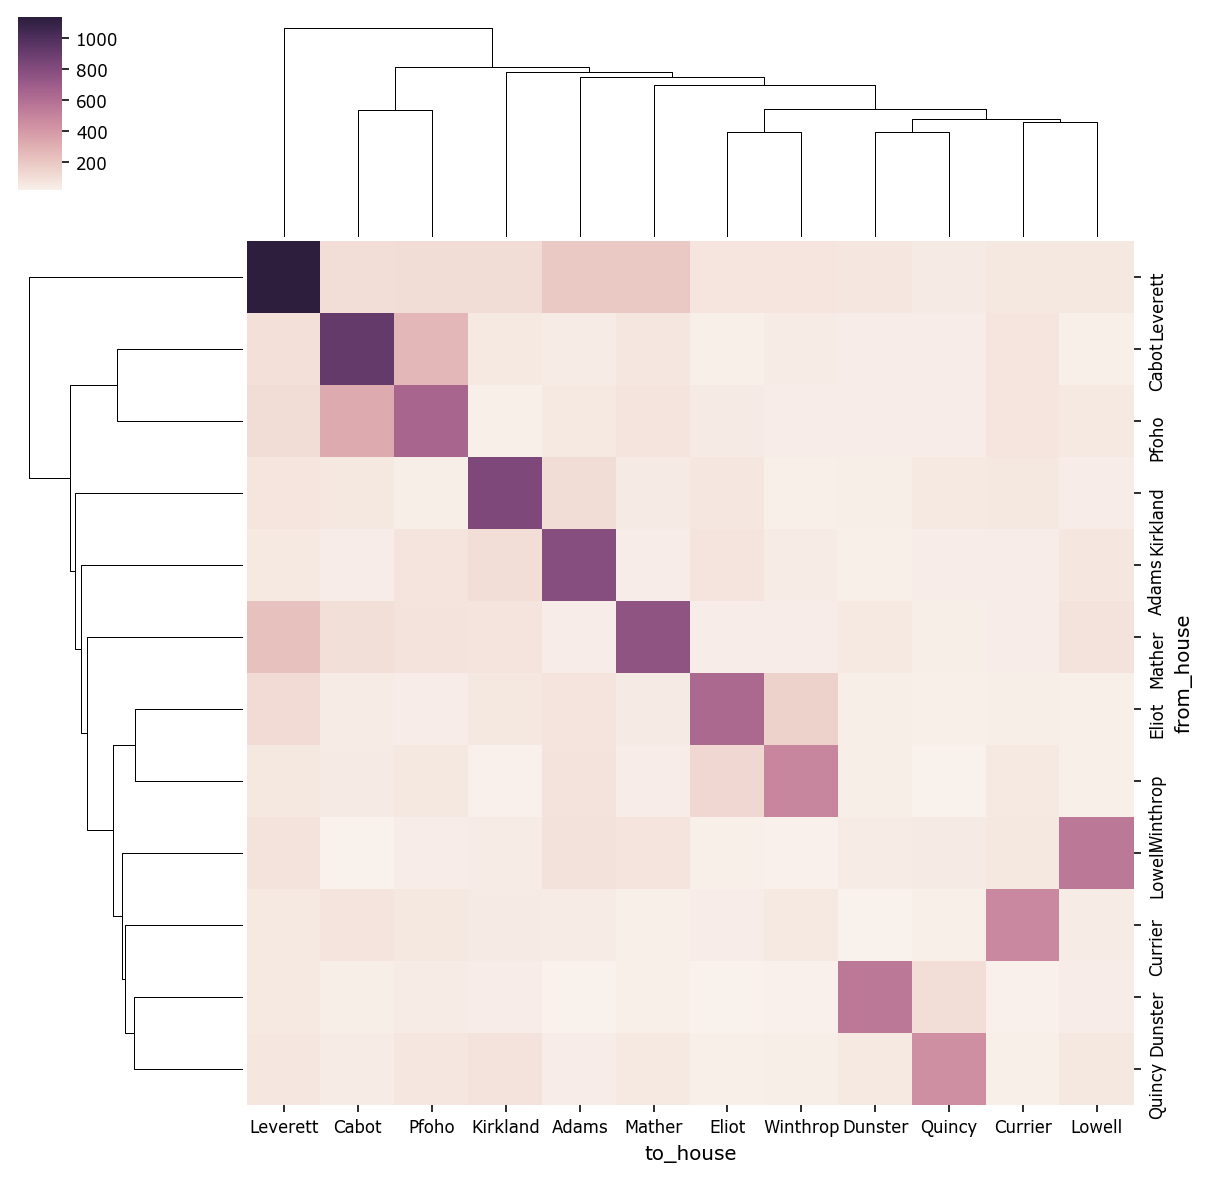

In [124]:
sns.clustermap(house_mat.loc[houses, houses].fillna(0))

### By year

In [125]:
yr_mat = transactions.groupby(['from_year', 'to_year']).size().unstack()
yrs = ['Sophomore', 'Junior', 'Senior']
yr_mat.loc[yrs, yrs] / 35956

to_year,Sophomore,Junior,Senior
from_year,,,
Sophomore,0.546168,0.105156,0.104044
Junior,0.087246,0.771721,0.207921
Senior,0.067833,0.182501,1.000000


/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


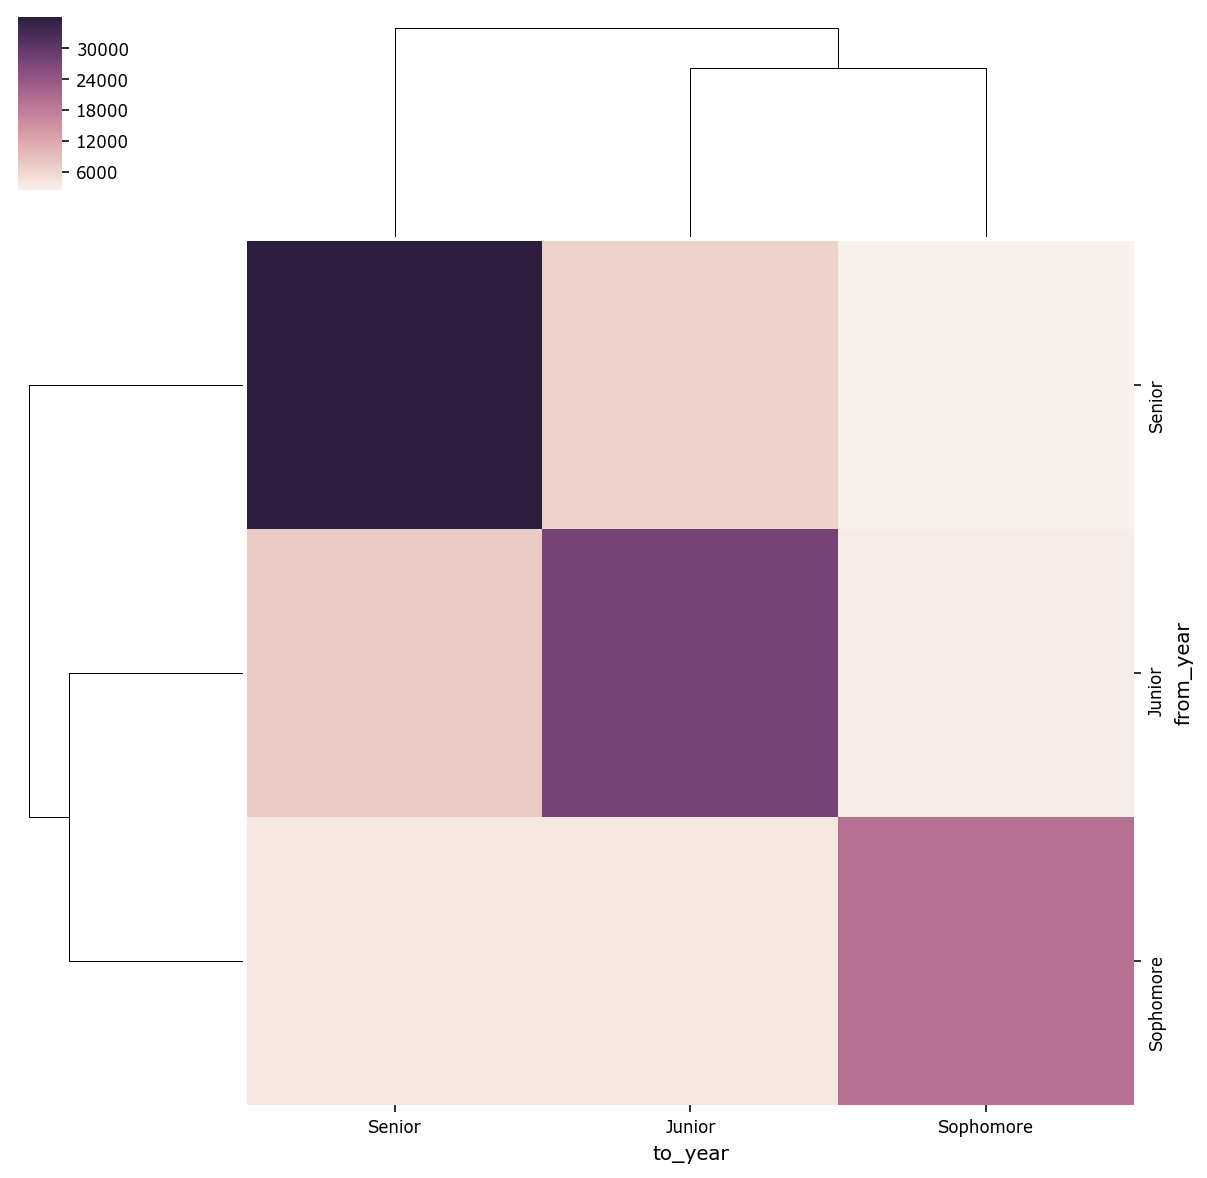

In [126]:
sns.clustermap(yr_mat)

In [95]:
harvard[(harvard['First Name'] == 'Rachel') & (harvard['Year'] == 'Sophomore')]

,Last Name,First Name,Email,Phone,House,Year,Assigned House,name
1759,Damle,Rachel,rachel_damle@college,(303) 870-4037,Adams,Sophomore,Adams,Rachel Damle
1898,Freed,Rachel,rachel_freed@college,(781) 248-4954,Kirkland,Sophomore,Kirkland,Rachel Freed
2065,Hong,Rachel,rachelhong@college,(858) 492-7370,Leverett,Sophomore,Leverett,Rachel Hong
2297,Levy,Rachel,rachel_levy@college,NaN,NaN,Sophomore,NaN,Rachel Levy
2363,Ma,Rachel,rachel_ma@college,(732) 332-0696,Eliot,Sophomore,Eliot,Rachel Ma
2620,Phan,Rachel,rphan@college,NaN,Eliot,Sophomore,Eliot,Rachel Phan
2776,Share-Sapolsky,Rachel,rachelsharesapolsky@college,(415) 828-9021,Cabot,Sophomore,Cabot,Rachel Share-Sapolsky
2813,Slater,Rachel,rachelslater@college,NaN,Cabot,Sophomore,Cabot,Rachel Slater
